<a href="https://colab.research.google.com/github/andrea-gasparini/foundations-data-science/blob/master/project/FDS_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Foundations of Data Science - Final Project

> Andrea Gasparini, 1813486 <br>
> Edoardo Di Paolo, 1728334 <br>
> Cirillo Atalla, 1755033 <br>

## Colab setup and Libraries import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

dataset_path = "/content/drive/MyDrive/dataset.json"

Mounted at /content/drive


In [2]:
import os
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from ctypes import Union
from typing import List

from sklearn.feature_extraction.text import HashingVectorizer, CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, roc_curve
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from networkx import json_graph, diameter, strongly_connected_components, DiGraph
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

!pip install jsonlines
import jsonlines

## Dataset

In [3]:
def load_json_dataset(filename):
    """
    Loads the dataset from a JSON Lines file and parses it to have a list of functions.

    :param filename: A JSON Lines filename
    :type filename: str
    :returns: The list of functions, the list of target classes, the set of the class names and the list of DiGraphs
    :rtype: (List[List[str]], List[str], set, List[DiGraph])
    """
    data: List[List[str]] = list()
    target: List[str] = list()
    target_list = set()
    nx_graphs: List[DiGraph] = list()

    with jsonlines.open(filename) as file:
        for line in file:
            # loads the function as a string from the file
            function: str = line["lista_asm"]
            
            # parses the function to have a list of its instructions
            instructions: list = [instr[1:] for instr in function[1:-1].split("', ")]
            data.append(instructions)

            nx_graph: DiGraph = json_graph.adjacency_graph(line["cfg"])
            nx_graphs.append(nx_graph)

            # extracts the target classes list
            line_class: str = line["semantic"]
            target.append(line_class)
            target_list.add(line_class)

    return data, target, target_list, nx_graphs

## Preprocessing and Feature Extraction

In [4]:
def process_data(data, nx_graphs):
    """
    Extract the features from the lists of assembly functions and DiGraphs

    :type data: List[List[str]]
    :type nx_graphs: List[DiGraph]
    :rtype: numpy.ndarray
    """

    x64_ops = {
        "bitwise": ["xor", "or", "and", "not"],
        "arithmetic": ["inc", "dec", "neg", "leaq", "add", "sub", "mul", "divq"],
        "shift": ["sal", "shl", "sar", "shr"],
        "movement": ["lea", "mov", "push", "pop"],
        "calls": ["call", "leave", "ret"]
    }

    new_data = list()

    for i, function in enumerate(data):

        bitwise_count = arithmetic_count = shift_count = calls_count = \
            movement_count = xmm_count = cmp_count = 0

        for instr in function:
            bitwise_count += sum([instr.count(op) for op in x64_ops["bitwise"]])
            shift_count += sum([instr.count(op) for op in x64_ops["shift"]])
            movement_count += sum([instr.count(op) for op in x64_ops["movement"]])
            arithmetic_count += sum([instr.count(op) for op in x64_ops["arithmetic"]])
            calls_count += sum([instr.count(op) for op in x64_ops["calls"]])
            xmm_count += instr.count("xmm")
            cmp_count += instr.count("cmp")

        graph = nx_graphs[i]
        graph_nodes = len(graph.nodes())
        graph_diameter = max([diameter(graph.subgraph(cc_set)) for cc_set in strongly_connected_components(graph)])
        complexity = len(graph.edges()) - graph_nodes - nx.components.number_strongly_connected_components(graph)

        new_data.append([graph_nodes, graph_diameter, movement_count, bitwise_count,
                        xmm_count, arithmetic_count, cmp_count, shift_count, calls_count])

    return np.array(new_data)

## Model selection

In [5]:
def get_model(data_train, target_train, model_type):
    """
    Returns a model fitted with training data

    :type data_train: list of list
    :type target_train: list
    :type model_type: str
    :rtype: Union[DecisionTreeClassifier, SVC, LogisticRegression]
    """

    if model_type == "decision_tree":
        model = DecisionTreeClassifier().fit(data_train, target_train)
        print('Decision Tree Model created')
    elif model_type == "svm":
        model = SVC(kernel='linear', C=1).fit(data_train, target_train)
        print('SVM Model created')
    elif model_type == "regression":
        return LogisticRegression().fit(data_train, target_train)
        print('Logistic Regression Model created')
    else:
        raise Exception(model_type + " isn't a valid model type")

    return model

## Plots and visualization utilities

In [6]:
def plot_target_distribution(target):
    """
    Plots a bar histogram of the target classes distribution

    :param target: The list of target classes
    :type target: list
    :rtype: None
    """
    target_dict = {name: 0 for name in set(target)}

    for y in target:
        target_dict[y] += 1

    x = np.arange(len(target_dict.values()))
    plt.bar(x, height=target_dict.values())
    plt.xticks(x, target_dict.keys())
    plt.show()


def plot_confusion_matrix(y_true, y_pred, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=None)

    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    ax.set_ylim(len(classes) - 0.5, -0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    plt2 = plt.gcf()
    plt.show()

    return plt, ax


## Main

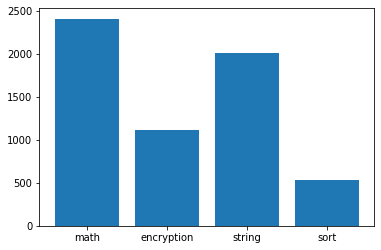

Train: 4068 - Test: 2005
SVM Model created
              precision    recall  f1-score   support

  encryption       0.98      0.95      0.96       366
        math       0.95      1.00      0.97       816
        sort       0.83      0.86      0.84       173
      string       0.98      0.93      0.95       650

    accuracy                           0.95      2005
   macro avg       0.93      0.93      0.93      2005
weighted avg       0.95      0.95      0.95      2005



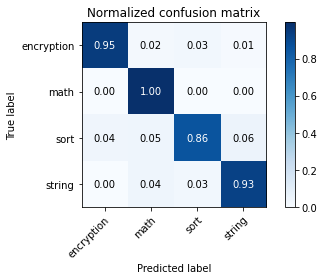

(<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7c31f677b8>)

In [7]:
model_type = "svm"
dataset_filename: str = dataset_path

data, y_all, class_names, graphs = load_json_dataset(dataset_filename)

plot_target_distribution(y_all)

X_all = process_data(data, graphs)

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.33, random_state=42)
print("Train: %d - Test: %d" % (X_train.shape[0], X_test.shape[0]))

model = get_model(X_train, y_train, model_type)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

plot_confusion_matrix(y_test, y_pred, normalize=True)